# Quick Start Guide
This tutorial shows how to use the resampling capabilities in scarlet

In [1]:
# Import Packages and setup
import logging

import numpy as np

import scarlet
import scarlet.display
import astropy.io.fits as fits
from astropy.wcs import WCS
import sep

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

## Load and display the sample data

### Load the sample data and source catalog
Loading the source catalog requires astropy. If you don't have astropy installed you'll have to do the source detection yourself. For example, using `sep`.

In [2]:

def makeCatalog(img):
    if np.size(img.shape) == 3:
        detect = img.mean(axis=0) # simple average for detection
    else:
        detect = img.byteswap().newbyteorder()
        
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, 4, err=bkg.globalrms)
    if np.size(img.shape) == 3:
        bg_rms = np.array([sep.Background(band).globalrms for band in img])
    else:
        bg_rms =  sep.Background(detect).globalrms
    return catalog, bg_rms




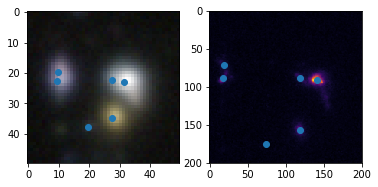

In [3]:
obs_hdu = fits.open('../data/test_resampling/Cut_HSC1.fits')
data_obs = obs_hdu[0].data.byteswap().newbyteorder()
wcs_obs = WCS(obs_hdu[0].header)
psf_obs = fits.open('../data/test_resampling/PSF_HSC.fits')[0].data



x,y = np.where(psf_obs[0]*0==0)
Np1, Np2 = psf_obs[0].shape

scenehdu = fits.open('../data/test_resampling/Cut_HST1.fits')
data_scene = scenehdu[0].data
wcs_scene = WCS(scenehdu[0].header)
psf_scene = fits.open('../data/test_resampling/PSF_HST.fits')[0].data


noise = np.concatenate((np.concatenate((data_scene[0,:], data_scene[:,0])),
                                            np.concatenate((data_scene[-1,:], data_scene[:,-1]))))

n1,n2 = np.shape(data_scene)
data_scene = data_scene.reshape(1, n1, n2).byteswap().newbyteorder()/np.max(data_scene)

r, N1, N2 = data_obs.shape

catalog, bg_rms = makeCatalog(data_scene)

#plotting setup
norm = scarlet.display.Asinh(img=data_obs, Q=20)
# Map i,r,g -> RGB
filter_indices = [2,0,1]

xo,yo = catalog['x'], catalog['y']

ra, dec = wcs_scene.wcs_pix2world(yo,xo,0)
Yo,Xo, l = wcs_obs.wcs_world2pix(ra, dec, 0, 0)

img_rgb = scarlet.display.img_to_rgb(data_obs, filter_indices=filter_indices, norm=norm)
plt.subplot(121)
plt.imshow(img_rgb)
plt.plot(Xo,Yo, 'o')
plt.subplot(122)
plt.imshow(data_scene[0])
plt.plot(xo,yo, 'o')
plt.show()

## Initialize the sources
Each source is a list of fundamental `scarlet.Component` instances and must be based on `scarlet.Source` or a derived class, in this case `ExtendedSource`, which enforces that the source is monotonic and symmetric.

In [4]:
scene = scarlet.Scene((4, n1, n2), wcs = wcs_scene, psfs = psf_scene)

obs_1 = scarlet.Observation(data_scene, wcs = wcs_scene, psfs = None)
obs_2 = scarlet.Combination(data_obs,  wcs = wcs_obs, psfs = psf_obs)

obs = [obs_1, obs_2]
# In[5]:
sources = [scarlet.Extended_CombinedSource((ra[i], dec[i]), scene, obs, bg_rms, symmetric = 0, monotonic = 1) for i in range(ra.size)]


## Create and fit the model
The `scarlet.Blend` class represent the sources as a tree and has the machinery to fit all of the sources to the given images. In this example the code is set to run for a maximum of 200 iterations, but will end early if the likelihood and all of the constraints converge.

In [5]:
blend = scarlet.Blend(scene, sources, obs)

blend.fit(500)
print("scarlet ran for {0} iterations".format(blend.it))

/Users/remy/Desktop/LSST_Project/scarlet/scarlet/observation.py:320: ComplexWarning: Casting complex values to real discards the imaginary part
  kernel_fft[target_fft != 0] = observed_fft[target_fft != 0] / target_fft[target_fft != 0]


Failed in recentering for source at (91, 138) in iteration 16
scarlet ran for 500 iterations


### View the full model
First we load the model for the entire blend and its residual. Then we display the model using the same $sinh^{-1}$ stretch as the full image and a linear stretch for the residual.

(4, 200, 200)


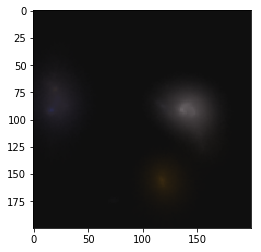

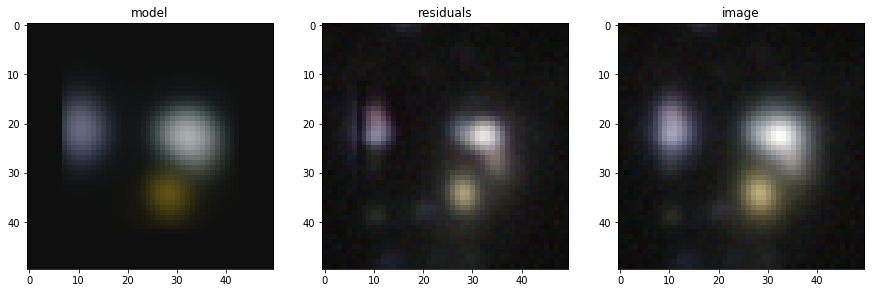

In [6]:
# Load the model and calculate the residual
im = np.zeros((N1,N2))
im[obs_2._over_lr[0].astype(int), obs_2._over_lr[1]] = np.dot(data_scene.flatten(),obs_2.resconv_op[1,:,:])

model = blend.get_model()

print(model.shape)

modelhr_rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
plt.imshow(modelhr_rgb)
plt.show()

img = obs_2.get_model_image(model)

model_rgb = scarlet.display.img_to_rgb(img, filter_indices=filter_indices, norm=norm)
residual = data_obs-img
residual_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices, norm=norm)


plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('model')
plt.imshow(model_rgb)
plt.subplot(132)
plt.title('residuals')
plt.imshow(residual_rgb)
plt.subplot(133)
plt.title('image')
plt.imshow(img_rgb)
plt.show()

### View the source models
It can also be useful to view the model for each source. For each source we extract the portion of the image contained in the sources bounding box, the true simulated source flux, and the model of the source, scaled so that all of the images have roughly the same pixel scale.

(4, 200, 200)
[0.30991681 0.         0.44486265 0.        ] 1.0


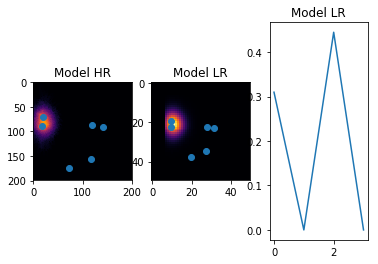

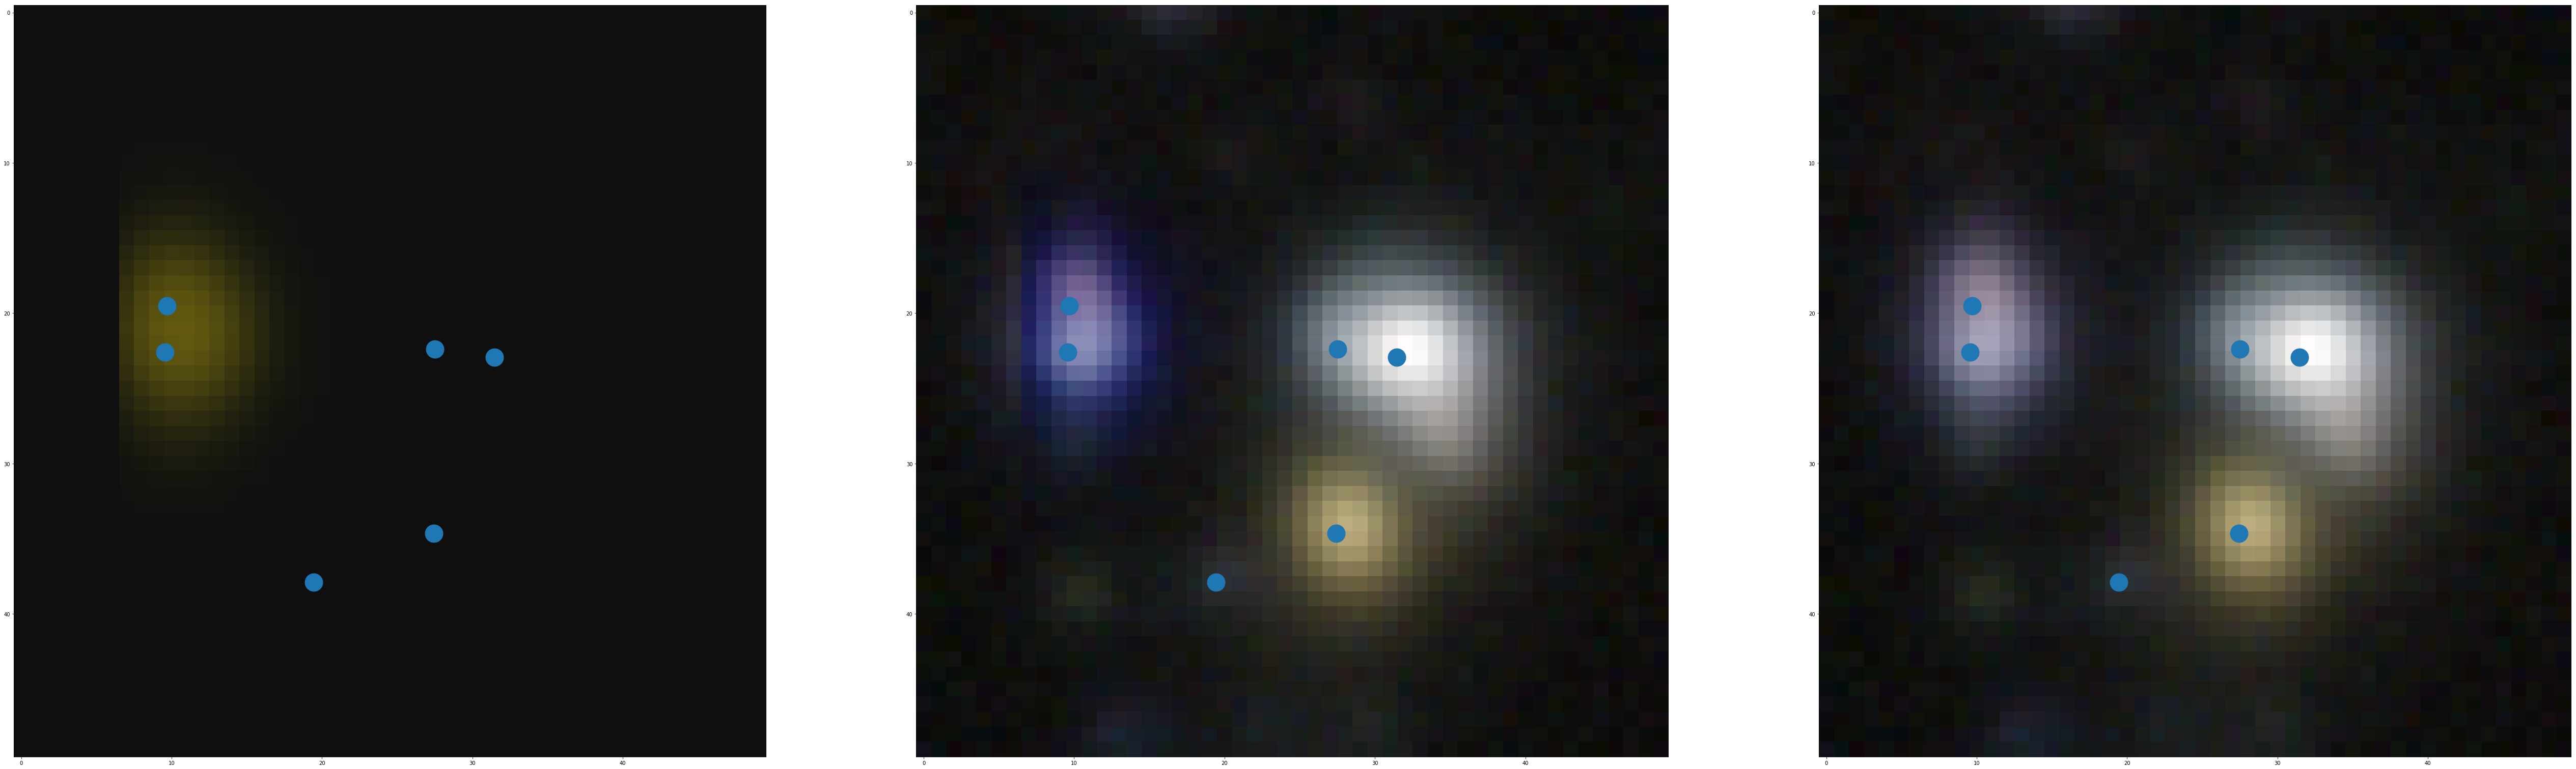

(4, 200, 200)
[0.1566647  0.9523709  0.05278311 0.13068234] 1.0


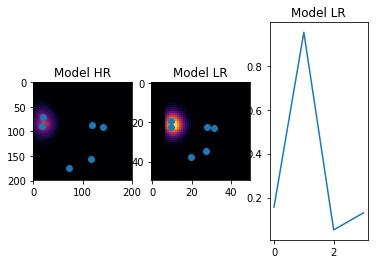

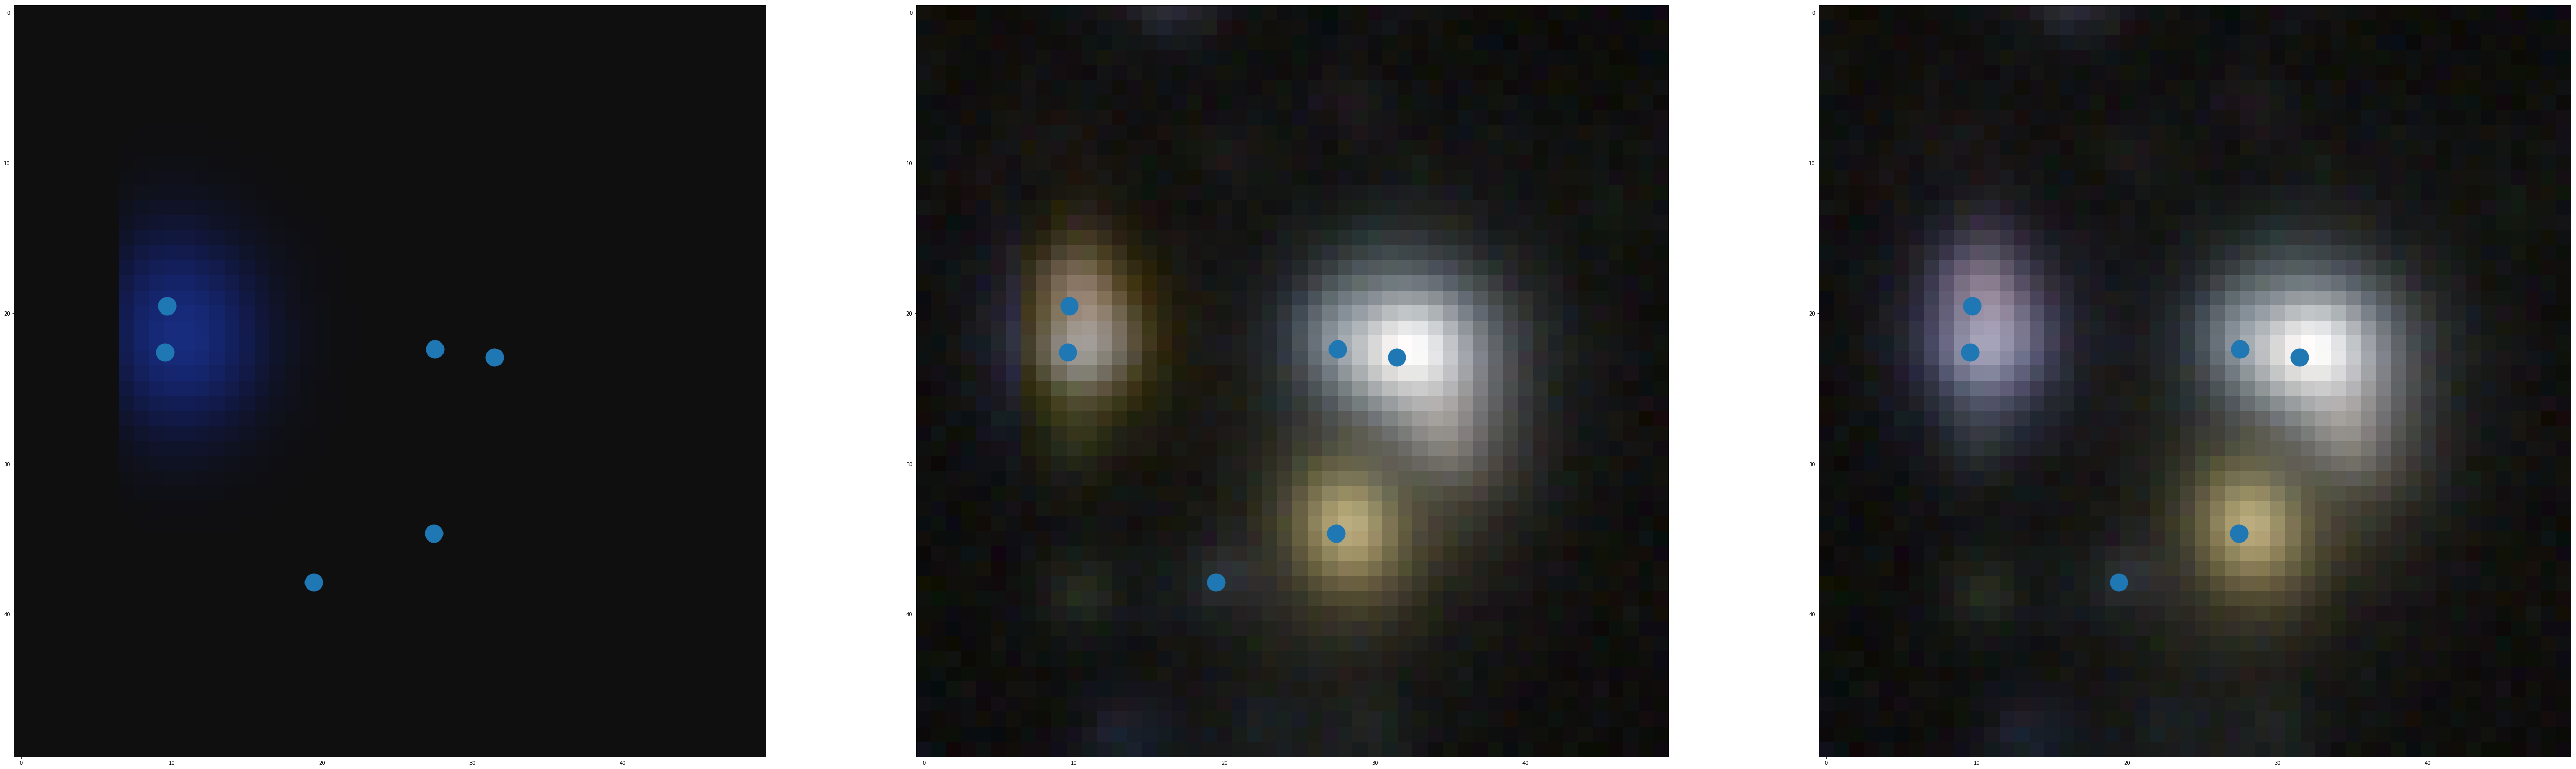

(4, 200, 200)
[0.00734309 0.05363169 0.         0.03378841] 1.0


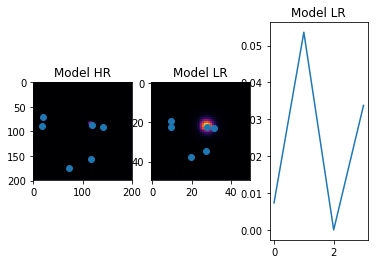

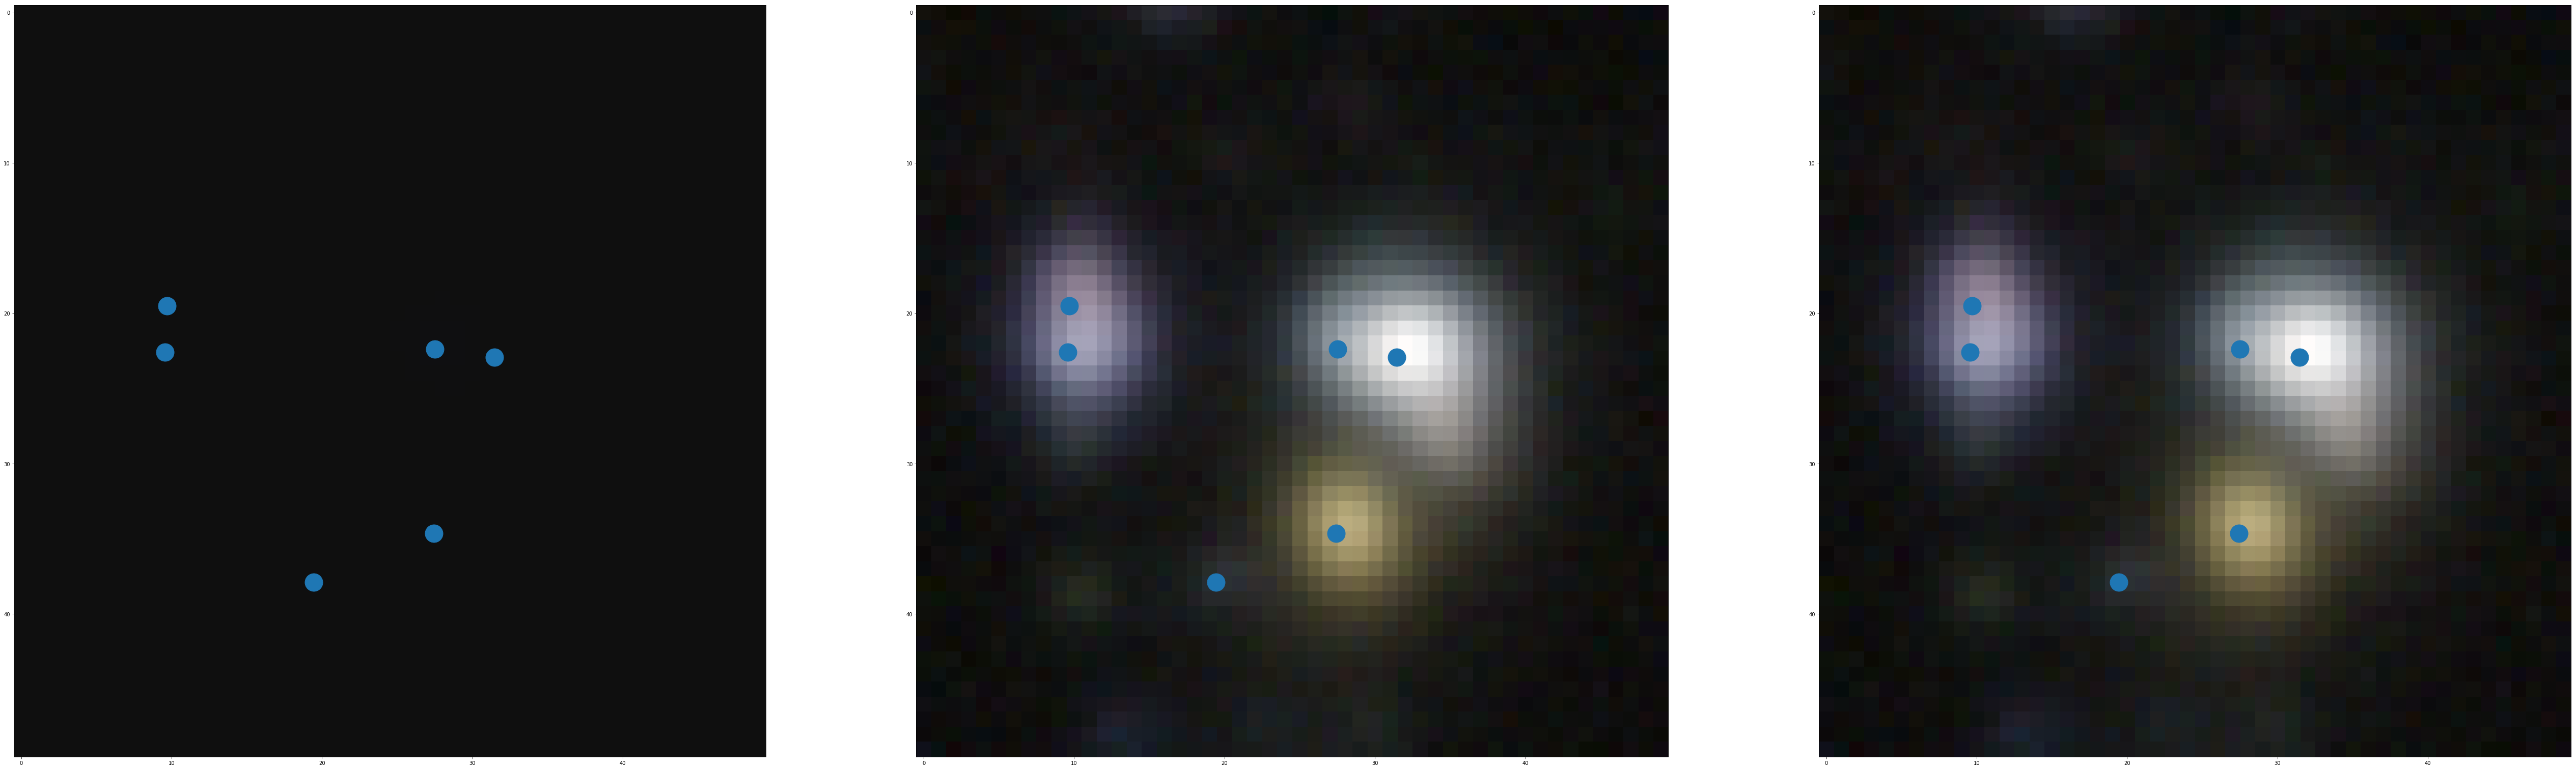

(4, 200, 200)
[1.6015398  1.69293323 1.77569618 0.33726484] 1.0


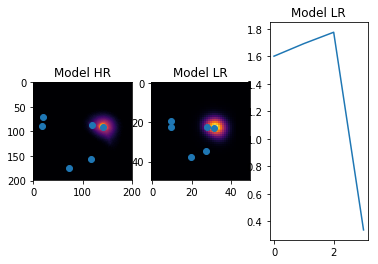

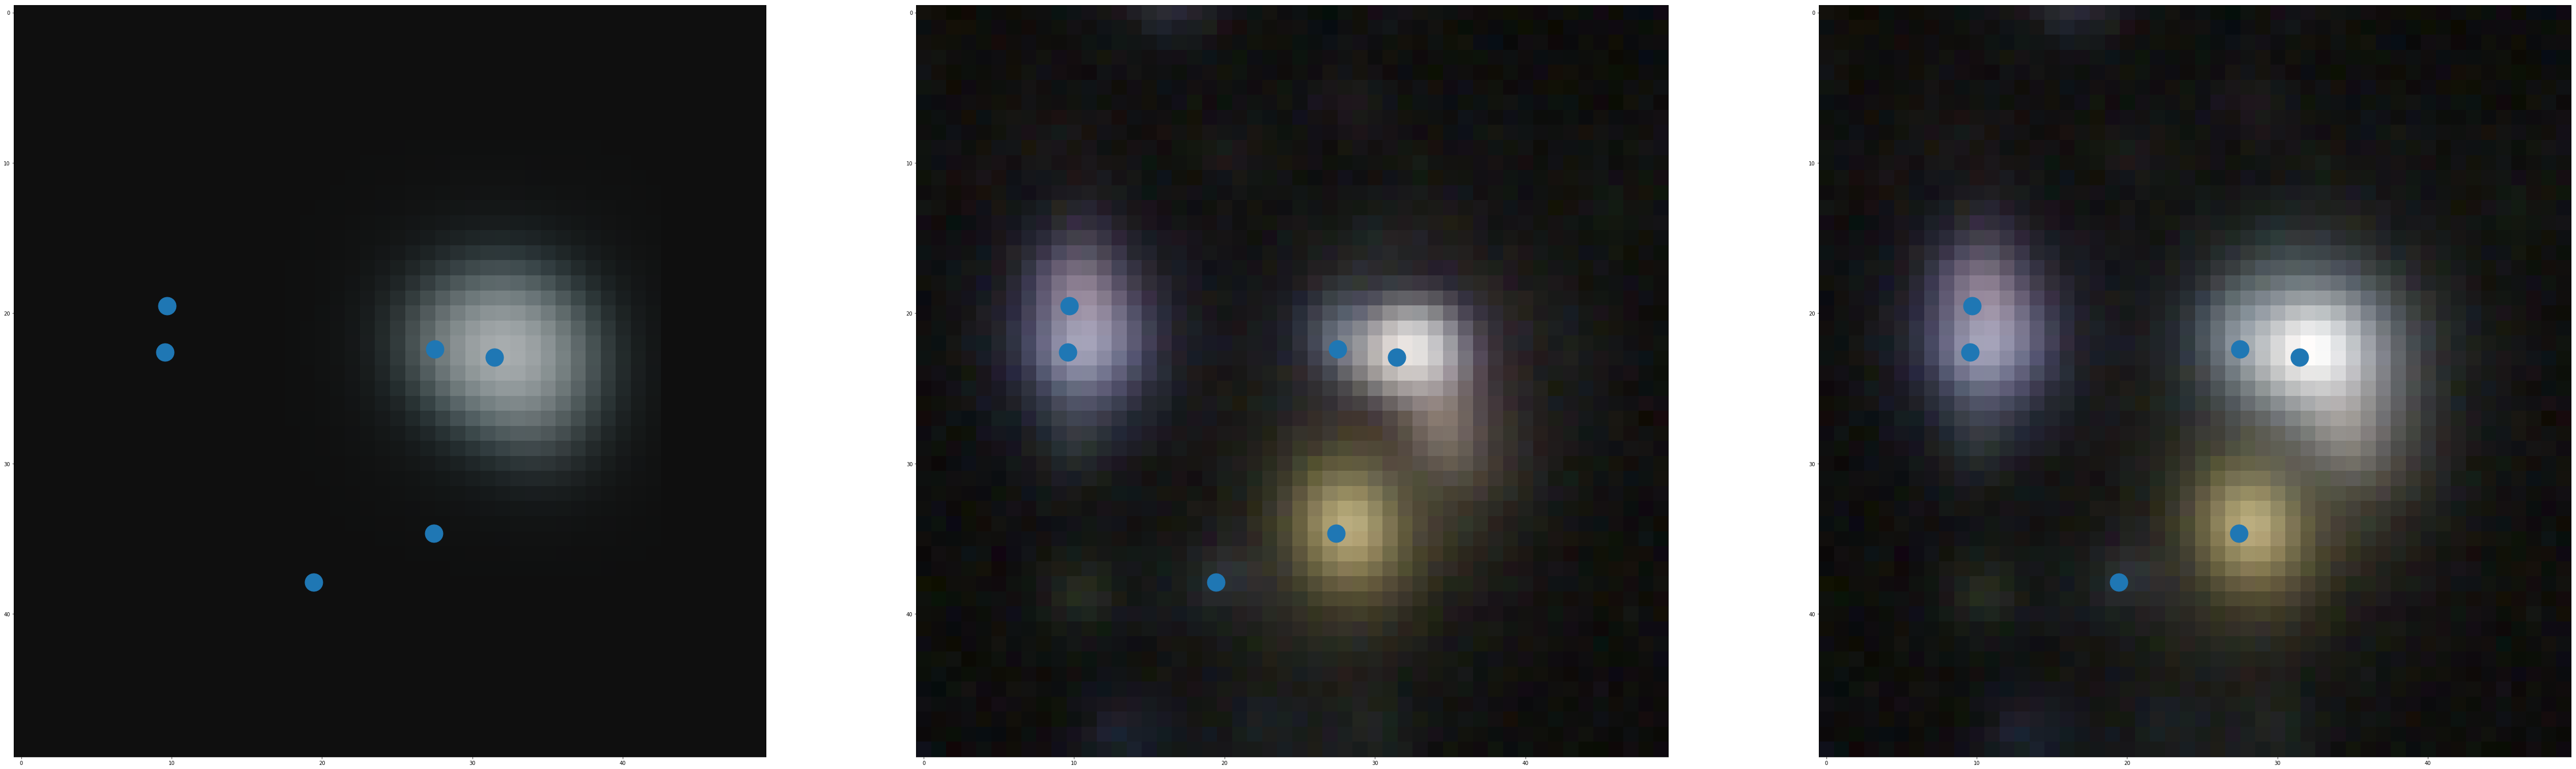

(4, 200, 200)
[0.37978066 0.01582744 0.62890688 0.09233474] 1.0


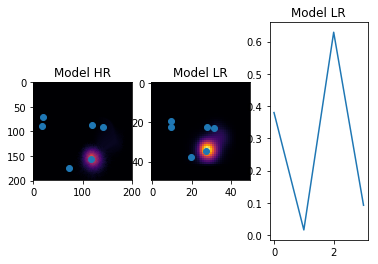

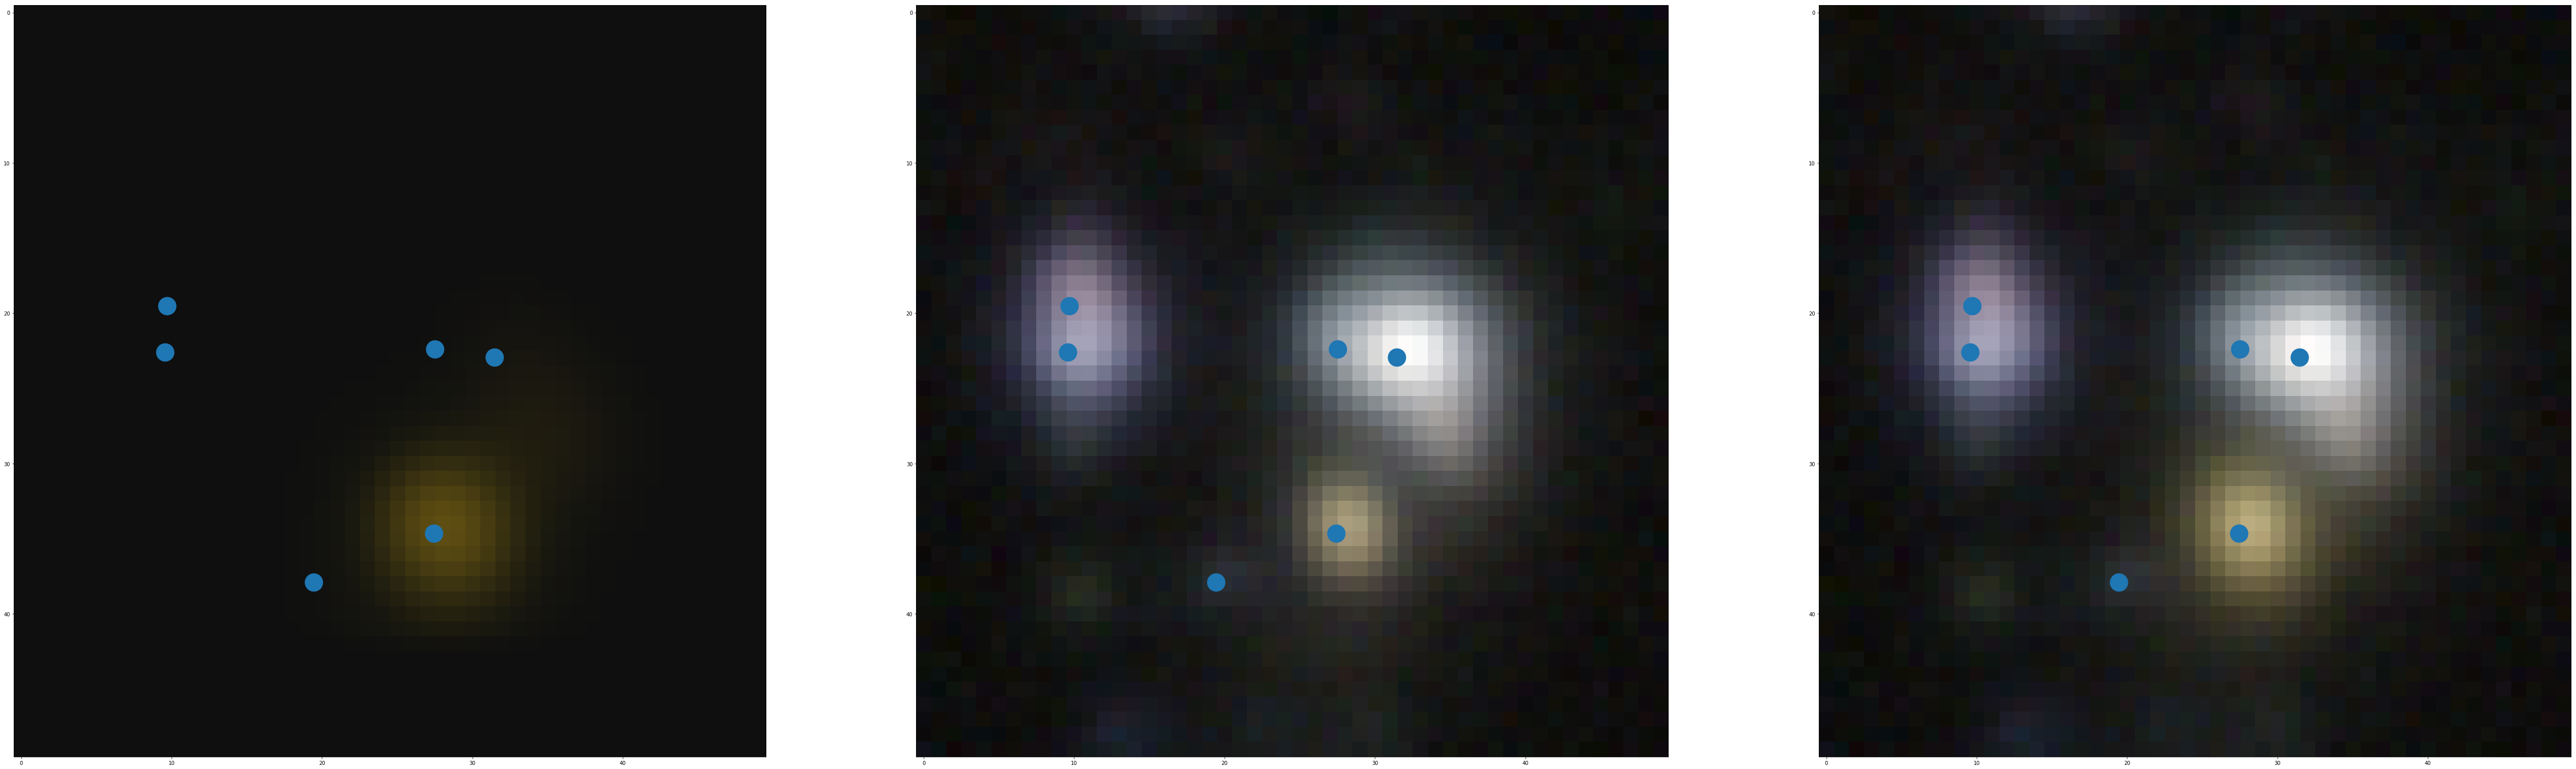

(4, 200, 200)
[0.0480128  0.05800646 0.05059601 0.03381752] 1.0


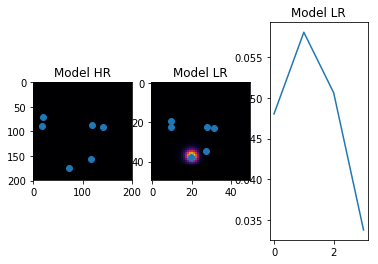

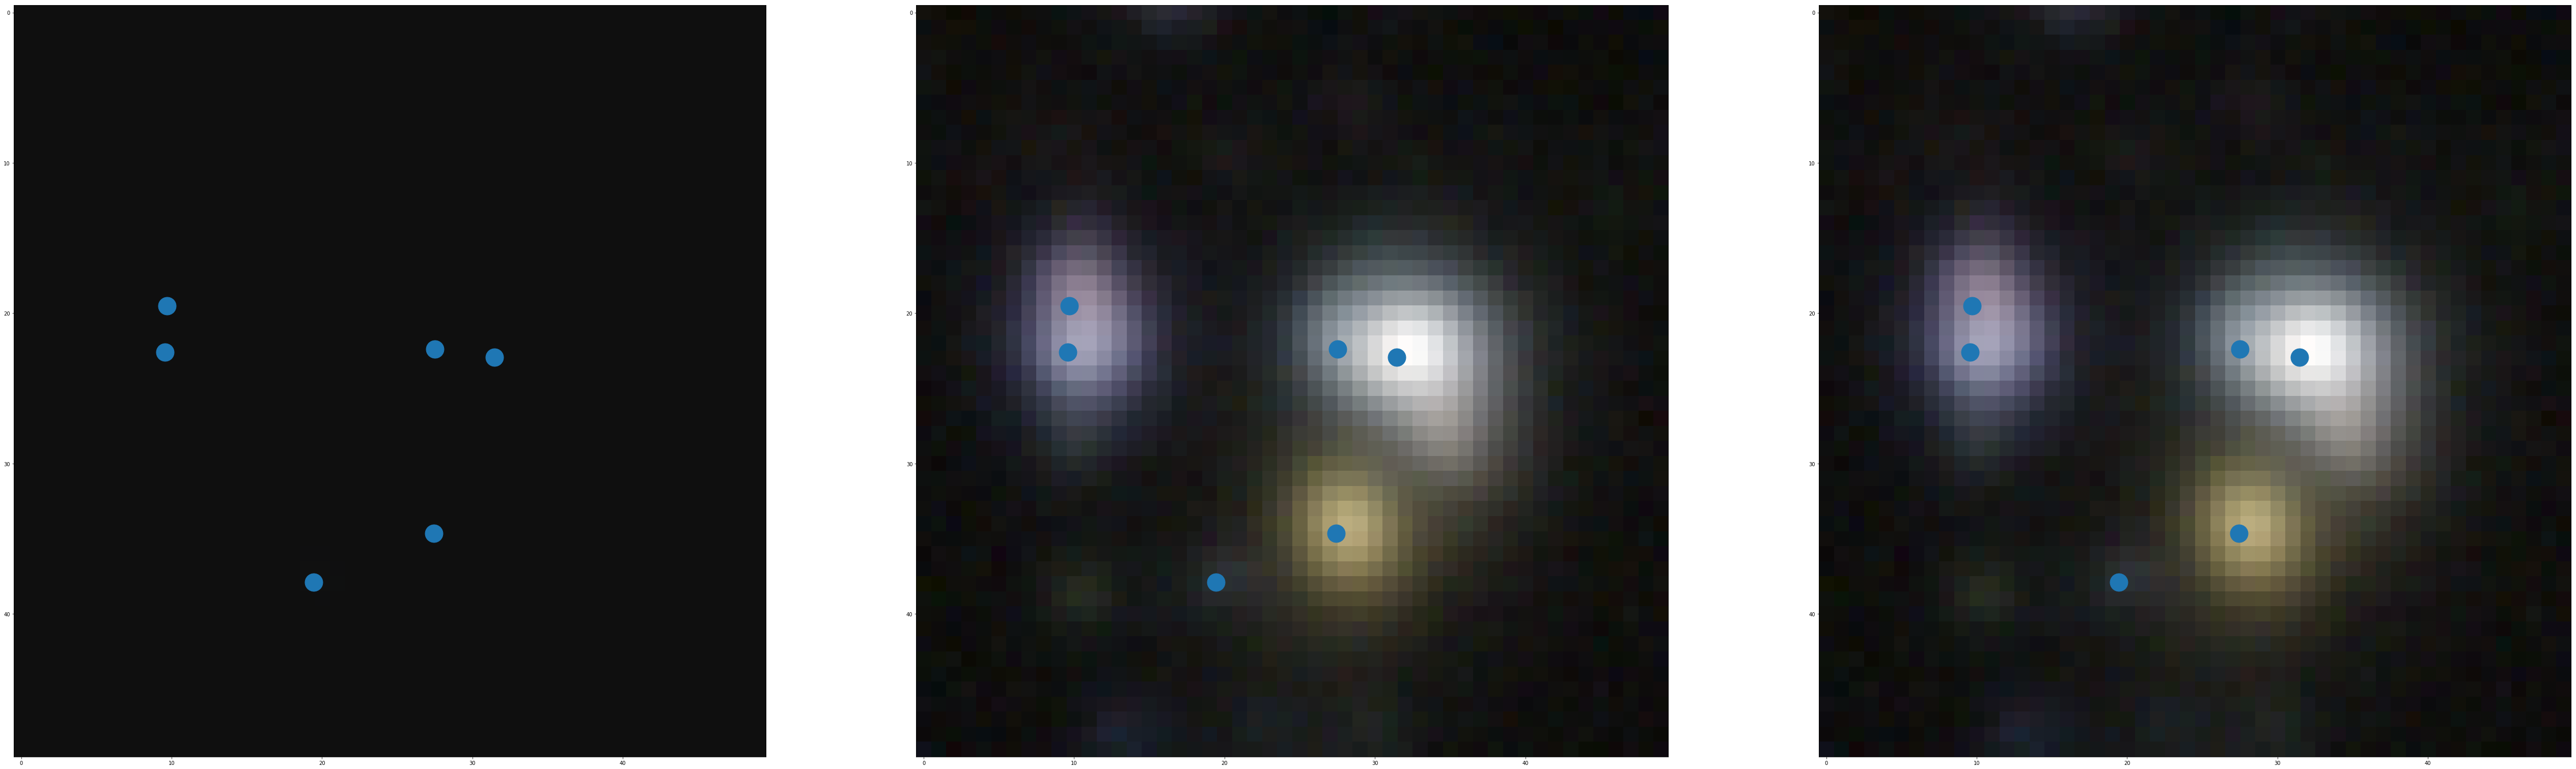

In [7]:
has_truth = False
axes = 2

for k,src in enumerate(blend.components):
    
    # Get the model for a single source
    component = blend.get_model(src.morph)

    print(component.shape)
    # Get the patch from the original image
    
    _img = src.morph
    print(src.sed, src.morph.max())
    plt.subplot(131)
    plt.imshow(_img[:,:])
    plt.plot(xo,yo, 'o')
    plt.title('Model HR')
    
    
    im = np.zeros((N1,N2))
    im[obs_2._over_lr[0].astype(int), obs_2._over_lr[1]] = np.dot(_img.flatten(),obs_2.resconv_op[0,:,:])
    plt.subplot(132)
    plt.imshow(im)
    plt.plot(Xo,Yo, 'o')
    plt.title('Model LR')
    plt.subplot(133)
    plt.plot(src.sed)
    plt.title('Model LR')
    plt.show()
    
    _img = src.get_model()

    #_img_rgb = scarlet.display.img_to_rgb(_img)

    _img_lr = obs_2.get_model_image(_img)
    img_lr_rgb = scarlet.display.img_to_rgb(_img_lr, filter_indices=filter_indices, norm=norm)
    res = data_obs-_img_lr
    res_rgb = scarlet.display.img_to_rgb(res, filter_indices=filter_indices, norm=norm)
        # Set the figure size
    ratio = src.shape[2]/src.shape[1]
    fig_height = 3*src.shape[1]/20
    fig_width = max(3*fig_height*ratio,2)
    fig = plt.figure(figsize=(fig_width, fig_height))
    # Generate and show the figure
    
    plt.subplot(131)
    plt.imshow(img_lr_rgb)
    plt.plot(Xo,Yo, 'o', markersize = 35)
    plt.subplot(132)
    plt.imshow(res_rgb)
    plt.plot(Xo,Yo, 'o', markersize = 35)
    plt.subplot(133)
    plt.imshow(img_rgb)
    plt.plot(Xo,Yo, 'o', markersize = 35)
    plt.show()

